In [ ]:
!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

!pip install pytorch-transformers

fatal: destination path 'stepik-dl-nlp' already exists and is not an empty directory.


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from IPython.display import clear_output
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
df = pd.read_csv('/content/lenta10k.csv')

In [ ]:
df.head()

,Unnamed: 0,url,title,text,topic,tags,date
0,0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


In [ ]:
df.topic.value_counts()

Россия            5135
Мир               2018
Экономика         1545
Интернет и СМИ     937
Спорт              360
Библиотека           5
Name: topic, dtype: int64

In [ ]:
all_topics = list(df.topic.unique())
unpopular_topics = [
    'Спорт', 
    'Библиотека', 
]
topics = [topic for topic in all_topics if topic not in unpopular_topics]
clean_df = df[df['topic'].isin(topics)].dropna()
mapping = {}
for i, v in enumerate(topics):
    mapping[v] = i
clean_df['topic'] = clean_df['topic'].replace(mapping)
clean_df.head()

,Unnamed: 0,url,title,text,topic,tags,date
5,5,https://lenta.ru/news/1999/08/31/stancia_mir/,"Космонавты сомневаются в надежности ""Мира""",Как стало известно агентству Ассошиэйтед Пресс...,0,Все,1999/08/31
6,6,https://lenta.ru/news/1999/08/31/vzriv/,Взрыв в центре Москвы: пострадало 30 человек,В зале игровых автоматов в третьем ярусе подзе...,0,Все,1999/08/31
7,7,https://lenta.ru/news/1999/08/31/credit_japs/,Япония кредитует Россию на полтора миллиарда д...,Япония приняла решение разморозить кредиты Рос...,0,Все,1999/08/31
8,8,https://lenta.ru/news/1999/08/31/diana/,Британцы отмечают двухлетие смерти Дианы,Британцы отмечают сегодня скорбную дату - втор...,1,Все,1999/08/31
9,9,https://lenta.ru/news/1999/08/31/mvf/,Отмытые через Bank of NY деньги не имели отнош...,В понедельник директор департамента внешних св...,0,Все,1999/08/31


In [12]:
def calculate_bert(sentences, clean_df):
  train_sentences, test_sentences, train_topics, test_topics = train_test_split(
      sentences, clean_df['topic'].values, test_size=0.3
  )
  print(f'Размер выборки {len(train_sentences)} {len(test_sentences)}')

  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  tokenized_texts = [tokenizer.tokenize(sentence) for sentence in train_sentences]

  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
  input_ids = pad_sequences(
      input_ids,
      maxlen=512,
      dtype="long",
      truncating="post",
      padding="post"
  )

  attention_masks = [[float(i>0) for i in seq] for seq in input_ids]
  train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_topics, 
    random_state=42,
    test_size=0.2
  )
  train_masks, validation_masks, _, _ = train_test_split(
      attention_masks,
      input_ids,
      random_state=42,
      test_size=0.2
  )
  train_inputs = torch.tensor(train_inputs)
  train_labels = torch.tensor(train_labels)
  train_masks = torch.tensor(train_masks)
  validation_inputs = torch.tensor(validation_inputs)
  validation_labels = torch.tensor(validation_labels)
  validation_masks = torch.tensor(validation_masks)
  device = torch.device("cuda")
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_dataloader = DataLoader(
      train_data,
      sampler=RandomSampler(train_data),
      batch_size=12
  )

  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  validation_dataloader = DataLoader(
      validation_data,
      sampler=SequentialSampler(validation_data),
      batch_size=12
  )
  model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(clean_df['topic'].values))
  model.cuda()

  param_optimizer = list(model.named_parameters())
  no_decay = ['bias', 'gamma', 'beta']
  optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
      {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
  ]

  optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
  train_loss_set = []
  train_loss = 0

  model.train()
  for step, batch in enumerate(train_dataloader):
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      
      optimizer.zero_grad()
      loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      train_loss_set.append(loss[0].item())  
      loss[0].backward()
      optimizer.step()

      train_loss += loss[0].item()
      
      clear_output(True)
      plt.plot(train_loss_set)
      plt.title("Training loss")
      plt.xlabel("Batch")
      plt.ylabel("Loss")
      plt.show()
  print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

  model.eval()
  valid_preds, valid_labels = [], []
  for batch in validation_dataloader:   
      batch = tuple(t.to(device) for t in batch)
      b_input_ids, b_input_mask, b_labels = batch
      with torch.no_grad():
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = logits[0].detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      
      batch_preds = np.argmax(logits, axis=1)
      batch_labels = label_ids
      valid_preds.extend(batch_preds)
      valid_labels.extend(batch_labels)

  print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
      accuracy_score(valid_labels, valid_preds) * 100
  ))

Весь текст статьи(до максимальный длины обработки)

In [10]:
sentences = clean_df['text'].values
for index, sentence in enumerate(sentences):
    if len(sentence) > 512:
        sentences[index] = sentence[:512]
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

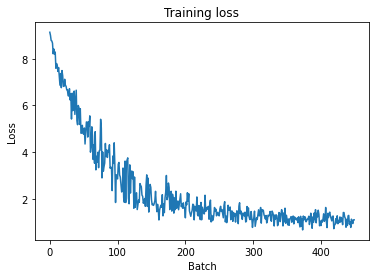

Loss на обучающей выборке: 2.38798
Процент правильных предсказаний на валидационной выборке: 65.09%


In [13]:
calculate_bert(sentences, clean_df)

Результаты Loss 2.38798, Accuracy 65.9%

Только начало статьи

In [14]:
sentences = clean_df['text'].values
for index, sentence in enumerate(sentences):
    if len(sentence) > 100:
        sentences[index] = sentence[:100]
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

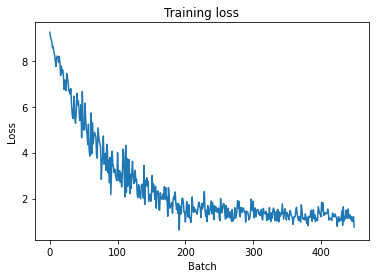

Loss на обучающей выборке: 2.50995
Процент правильных предсказаний на валидационной выборке: 53.74%


In [15]:
calculate_bert(sentences, clean_df)

Результаты Loss 2.50995, Accuracy 53.74%

Только заголовок

In [16]:
sentences = clean_df['title'].values
for index, sentence in enumerate(sentences):
    if len(sentence) > 512:
        sentences[index] = sentence[:512]
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]

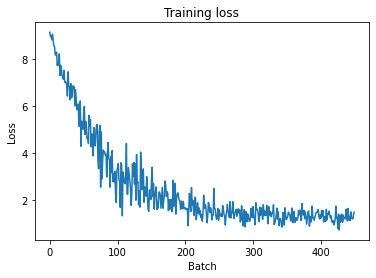

Loss на обучающей выборке: 2.53920
Процент правильных предсказаний на валидационной выборке: 52.48%


In [17]:
calculate_bert(sentences, clean_df)

Результаты Loss 2.53920, Accuracy 52.48%